In [1]:
import os

import tensorflow as tf

import time
import gym
import gym_cap
import gym_cap.envs.const as CONST
import numpy as np
import random
import math
import matplotlib.pyplot as plt
%matplotlib inline

# the modules that you can use to generate the policy. 
import policy.random
import policy.roomba
import policy.policy_RL
import policy.zeros

# Data Processing Module
from utility.dataModule import state_processor
#from utility.utils import MovingAverage as MA
from utility.utils import discount_rewards, store_args, q_retrace
#from utility.her import HER

from network.base import *

from tqdm import tqdm

%load_ext autoreload
%autoreload 2

In [2]:
!rm -rf logs/HER_Q/ model/HER_Q

In [3]:
TRAIN_NAME='HER_Q'
LOG_PATH='./logs/'+TRAIN_NAME
MODEL_PATH='./model/' + TRAIN_NAME
GPU_CAPACITY=0.5 # gpu capacity in percentage

In [4]:
# Experience replay buffer
class Buffer():
    def __init__(self, buffer_size = 50000):
        self.buffer = []
        self.buffer_size = buffer_size

    def add(self, experience):
        self.buffer.append(experience)
        if len(self.buffer) > self.buffer_size:
            self.buffer = self.buffer[int(0.0001 * self.buffer_size):]

    def sample(self,size):
        if len(self.buffer) >= size:
            experience_buffer = self.buffer
        else:
            experience_buffer = self.buffer * size
        return np.copy(np.reshape(np.array(random.sample(experience_buffer,size)),[size,4]))


In [5]:
def fully_connected_layer(inputs, dim, activation=None, scope="fc", reuse=None, init=tf.contrib.layers.xavier_initializer(), bias = True):
    with tf.variable_scope(scope, reuse = reuse):
        w_ = tf.get_variable("W_", [inputs.shape[-1], dim], initializer = init)
        outputs = tf.matmul(inputs, w_)
        if bias:
            b = tf.get_variable("b_", dim, initializer = tf.zeros_initializer())
            outputs += b
        if activation is not None:
            outputs = activation(outputs)
        return outputs

# Simple 1 layer feed forward neural network
class Model():
    @store_args
    def __init__(self, in_size, action_size, name, lr=1e-3):
        with tf.variable_scope(name):
            self.inputs = tf.placeholder(shape=in_size, dtype=tf.float32)
            self.Q_, self.predict = self.build_network(self.inputs)

            self.action = tf.placeholder(shape=None, dtype=tf.int32)
            self.Q_next = tf.placeholder(shape=None, dtype=tf.float32)
            self.train_op, self.loss = self.build_train(self.action, self.Q_next)
            
            self.init_op = tf.global_variables_initializer()

    def build_network(self, input_net):
        init = tf.contrib.layers.variance_scaling_initializer(factor = 1.0, mode = "FAN_AVG", uniform = False)

        hidden = fully_connected_layer(input_net, 128, activation=tf.nn.relu, init=init, scope="fc1")
        hidden = fully_connected_layer(hidden, 128, activation=tf.nn.relu, init=init, scope="fc2")
        hidden = fully_connected_layer(hidden, 128, activation=tf.nn.relu, init=init, scope="fc3")
        Q_ = fully_connected_layer(hidden, self.action_size, activation = None, scope = "Q", bias = False)
        predict = tf.argmax(Q_, axis = -1)

        return Q_, predict

    def build_train(self, action, q_next):
        action_onehot = tf.one_hot(action, self.action_size, dtype = tf.float32)
        Q = tf.reduce_sum(tf.multiply(self.Q_, action_onehot), axis = 1)
        loss = tf.reduce_sum(tf.square(q_next - Q))
        optimizer = tf.train.AdamOptimizer(learning_rate=self.lr)
        train_op = optimizer.minimize(loss)
        
        return train_op, loss


In [6]:
def updateTargetGraph(tfVars,tau):
    total_vars = len(tfVars)
    op_holder = []
    for idx,var in enumerate(tfVars[0:total_vars//2]):
        op_holder.append(tfVars[idx+total_vars//2].assign((var.value()*(1. - tau))
                                                          + (tau * tfVars[idx+total_vars//2].value())))
    return op_holder

def updateTarget(op_holder,sess):
    for op in op_holder:
        sess.run(op)


/home/namsong/anaconda3/envs/py36/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


Environment info
    number of blue agents : 1
    number of red agents  : 0


  0%|          | 0/100 [00:00<?, ?it/s]/home/namsong/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:118: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


<Figure size 432x288 with 0 Axes>

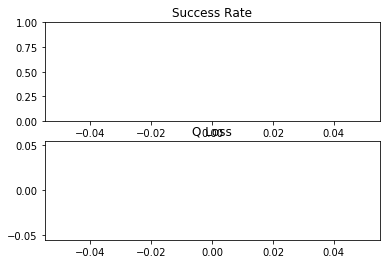

 53%|█████▎    | 53/100 [18:13:17<17:40:33, 1353.90s/it]

KeyboardInterrupt: 

In [7]:
# Replay Variables
total_episodes= 200000
max_ep = 150
entropy_beta = 0.01
trajectory_length = 150
train_frequency = 1  # not yet implemented
minibatch_size = 500

# Saving Related
save_network_frequency = 1200
save_stat_frequency = 128
moving_average_step = 128

# Training Variables
lr_a = 5e-5
lr_c = 2e-4

gamma = 0.98 # discount_factor

# Env Settings
MAP_SIZE = 50
VISION_RANGE = 19 # What decide the network size !!!
VISION_dX, VISION_dY = 2*VISION_RANGE+1, 2*VISION_RANGE+1
IN_SIZE = [None,VISION_dX*VISION_dY*6+4]
GPS_SIZE = [None, 2]
ACTION_SPACE = 5
N_AGENT = 1
NENV = 8

# Set environment
env = gym.make("cap-v0").unwrapped
env.reset(map_size=50,
          policy_red=policy.zeros.PolicyGen(env.get_map, env.get_team_red))
print(f'Environment info')
print(f'    number of blue agents : {len(env.get_team_blue)}')
print(f'    number of red agents  : {len(env.get_team_red)}')


shaped_reward = False
size = 150
num_epochs = 100          # Overall Epoch
num_cycles = 50
num_episodes = 32

optimisation_steps = 40
K = 4 # Goal replay count
buffer_size = 1e5
tau = 0.95
gamma = 0.98
batch_size = 256

total_rewards = []
total_loss = []
success_rate = []
succeed = 0

modelNetwork = Model(in_size = IN_SIZE, action_size=ACTION_SPACE, name = "model")
targetNetwork = Model(in_size = IN_SIZE, action_size=ACTION_SPACE, name = "target")
trainables = tf.trainable_variables()
updateOps = updateTargetGraph(trainables, tau)
buff = Buffer(buffer_size)

plt.figure()
fig = plt.figure()
ax = fig.add_subplot(211)
plt.title("Success Rate")
ax.set_ylim([0,1.])
ax2 = fig.add_subplot(212)
plt.title("Q Loss")
line = ax.plot(np.zeros(1), np.zeros(1), 'b-')[0]
line2 = ax2.plot(np.zeros(1), np.zeros(1), 'b-')[0]
fig.canvas.draw()

with tf.Session() as sess:
    sess.run(modelNetwork.init_op)
    sess.run(targetNetwork.init_op)
    for i in tqdm(range(num_epochs), total = num_epochs):
        for j in range(num_cycles):
            total_reward = 0.0
            successes = []
            for n in range(num_episodes):
                s0 = env.reset()
                local_view, global_position, goal = state_processor(s0, env.get_team_blue, VISION_RANGE, env._env, flatten=True, partial=False)
                episode_experience = []
                episode_succeeded = False

                # Episode Rollout
                for t in range(size):
                    state = np.concatenate([local_view, global_position], axis=1)
                    inputs = np.concatenate([state, goal], axis=1)
                    action = sess.run(modelNetwork.predict, feed_dict={modelNetwork.inputs:inputs})
                    action = action[0]
                    s_next, _, episode_succeeded, _ = env.step([action])
                    local_view, global_position, goal = state_processor(s_next, env.get_team_blue, VISION_RANGE, env._env, flatten=True, partial=False)
                    state_next = np.concatenate([local_view, global_position], axis=-1)
                    reward = -((goal==global_position)==0)
                    episode_experience.append((state, action, reward, state_next, goal))
                    total_reward += reward
                    if reward == 0:
                        succeed += 1
                        break
                successes.append(episode_succeeded)
                played_size = len(episode_experience)

                # Goal Replay
                for t in range(played_size):
                    s, a, r, s_n, g = episode_experience[t]
                    inputs = np.concatenate([s,g],axis = 1)
                    new_inputs = np.concatenate([s_n,g],axis = 1)
                    buff.add(np.reshape(np.array([inputs,a,r,new_inputs]),[1,4]))
                    # Action Replay
                    for k in range(K):
                        future = np.random.randint(t, played_size)
                        _, _, _, g_n, _ = episode_experience[future]
                        g_n=g_n[:,-2:]
                        inputs = np.concatenate([s,g_n],axis = -1)
                        new_inputs = np.concatenate([s_n, g_n],axis = -1)
                        final = np.sum(np.array(s_n[-2:]) == np.array(g_n)) == played_size
                        r_n = 0 if final else -1
                        buff.add(np.reshape(np.array([inputs,a,r_n,new_inputs]),[1,4]))

            # Train
            mean_loss = []
            for k in range(optimisation_steps):
                experience = buff.sample(batch_size)
                s, a, r, s_next = [np.squeeze(elem, axis = 1) for elem in np.split(experience, 4, 1)]
                s = [ss.reshape((-1,)) for ss in s]
                s = np.array(s)
                s = np.reshape(s, (batch_size, -1))
                s_next = np.array([ss.reshape((-1,)) for ss in s_next])
                s_next = np.reshape(s_next, (batch_size, -1))
                Q1 = sess.run(modelNetwork.Q_, feed_dict = {modelNetwork.inputs: s_next})
                Q2 = sess.run(targetNetwork.Q_, feed_dict = {targetNetwork.inputs: s_next})
                doubleQ = Q2[:, np.argmax(Q1, axis = -1)]
                Q_target = np.clip(r + gamma * doubleQ,  -1. / (1 - gamma), 0)
                _, loss = sess.run([modelNetwork.train_op, modelNetwork.loss], feed_dict = {modelNetwork.inputs: s, modelNetwork.Q_next: Q_target, modelNetwork.action: a})
                mean_loss.append(loss)

            # Graph
            success_rate.append(np.mean(successes))
            total_loss.append(np.mean(mean_loss))
            updateTarget(updateOps,sess)
            total_rewards.append(total_reward)
            ax.relim()
            ax.autoscale_view()
            ax2.relim()
            ax2.autoscale_view()
            line.set_data(np.arange(len(success_rate)), np.array(success_rate))
            # line.set_data(np.arange(len(total_rewards)), np.array(total_rewards))
            line2.set_data(np.arange(len(total_loss)), np.array(total_loss))
            fig.canvas.draw()
            fig.canvas.flush_events()
            plt.pause(1e-7)


    saver = tf.train.Saver()
    saver.save(sess, os.path.join(MODEL_PATH, "model.ckpt"))

    print("Number of episodes succeeded: {}".format(succeed))


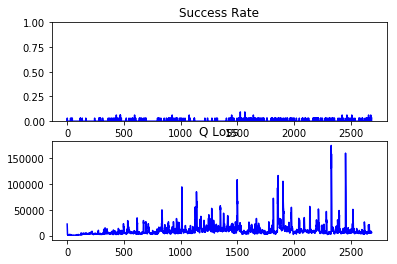

In [8]:
%matplotlib inline
fig
